In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from flifile import FliFile
import glob
import os
import skimage
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import timeit
from skimage.measure import LineModelND, ransac
import math
from sklearn.linear_model import RANSACRegressor, LinearRegression
from scipy.optimize import curve_fit

In [4]:
datafolder  = r'/home/preetham/Desktop/Project/200Torr'

In [204]:
def get_me_info(data):
    track_length_set_1 = np.zeros(100)
    angle_track_set_1 = np.zeros(100)
    energy_set_1 = np.zeros(100)
    sigma_set_1 = np.zeros(100)
    intensity_set_1 = np.zeros(100)
    nct_int_set_1 = np.zeros(100)
    #track  = np.zeros((1920,1200,100))

    data_clear = np.where(data<6, 0, data)
    clean_x = np.arange(0,99,1)
    clean_y = np.array([(np.sum(data_clear[:,:,i])) for i in range(0,99)])

    for i in range(0, 100):
        orig_image = data_clear[:, :, i].T
        masked_image = np.zeros_like(orig_image)
    
        # Create circular mask
        Y, X = np.ogrid[:orig_image.shape[0], :orig_image.shape[1]]
        dist_from_center = np.sqrt((X - center_x) ** 2 + (Y - center_y) ** 2)
        mask = dist_from_center <= radius
    
        # Apply mask
        masked_image[mask] = orig_image[mask]
    
        # Binarise image
        binary_image = np.where(masked_image > 0, 1, 0)
    
        # Make coordinates
        coords = np.nonzero(binary_image)
        coords_array = np.column_stack(coords)
    
        # DBSCAN CLUSTERING
        cluster_size_array = np.zeros(4200)
        count = 0
        db_eps = 29
        db_min_samp = 200
        dbscan = DBSCAN(eps=db_eps, min_samples=db_min_samp)
        dbscan.fit(coords_array)
        labels = dbscan.labels_
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise_ = list(labels).count(-1)
    
        if n_clusters_ > 0:
            clusters = [coords_array[labels == i] for i in range(n_clusters_)]
            clusters_size = [len(clusters[i]) for i in range(n_clusters_)]
            all_clusters = coords_array[labels != -1]
            max_cluster = np.max(clusters_size)  # how big is largest cluster
            cluster_size_array[count + 1] = max_cluster
            ind = np.array(clusters[np.argmax(clusters_size)])  # indices of points in largest cluster
            # Use the entire largest cluster directly
            cluster_mask = np.zeros_like(orig_image)
            x = ind[:, 0]
            y = ind[:, 1]
            for j in range(len(x)):
                x_i = x[j]
                y_i = y[j]
                cluster_mask[x_i, y_i] = 1
            Track = masked_image * cluster_mask
            '''
            X = ind[:, 0].reshape(-1, 1)  # Feature: column index 1
            y = ind[:, 1]                 # Target: column index 0
    
           
            
            # Define RANSACRegressor with same parameters
            ransac = RANSACRegressor(
                estimator=LinearRegression(),
                min_samples=10,
                residual_threshold=15,
                max_trials=1000,
                stop_score = 0.95
            )
    
            # Fit it
            ransac.fit(X, y)
    
            # Get inlier mask
            inliers = ransac.inlier_mask_
            outliers = ~inliers  # Logical NOT
    
            #Cluster_mask in case you want to plot in future
            cluster_mask = np.zeros_like(orig_image)
            x = ind[inliers,0]
            y = ind[inliers,1]
            for j in range(len(x)):
                x_j = x[j]
                y_j = y[j]
                cluster_mask[x_j,y_j] = 1
            Track = masked_image*cluster_mask'''
    
    
            # PCA From here
            X = np.column_stack((x, y))
            pca = PCA(n_components=2)
            pca.fit(X)
            for length, vector in zip(pca.explained_variance_, pca.components_):
                v = vector * 2.5 * np.sqrt(length)
                start_point = pca.mean_ - v
                end_point = pca.mean_ + v
    
            # Building Component 1
            length = pca.explained_variance_[0]
            vector = pca.components_[0]
            v = vector * np.sqrt(length)
    
            mean = pca.mean_
            end_midpoint = mean + 0.5 * v
            start_midpoint = mean - 0.5 * v
            end_point = mean + 1 * v
            start_point = mean - 1 * v
            pca1_start_point = mean - 2.5 * v
            pca1_end_point = mean + 2.5 * v
    
            length_v_pca1 = int(np.linalg.norm(v))
    
            width_of_line = 15
            profile_pc1 = skimage.measure.profile_line(
                Track,
                pca1_end_point,
                pca1_start_point,
                linewidth=width_of_line,
                mode='constant',
                cval=0,
                reduce_func=np.sum
            )
    
            # Building Component 2
            length = pca.explained_variance_[1]
            vector = pca.components_[1]
            v = vector * 3 * np.sqrt(length)
            cut1_start = start_point - v
            cut1_end = start_point + v
            cut2_start = start_midpoint - v
            cut2_end = start_midpoint + v
            cut3_start = mean - v
            cut3_end = mean + v
            cut4_start = end_midpoint - v
            cut4_end = end_midpoint + v
            cut5_start = end_point - v
            cut5_end = end_point + v
    
            start = (cut3_start[0], cut3_end[0])
            end = (cut3_start[1], cut3_end[1])
            profile_pc2 = skimage.measure.profile_line(
                Track,
                cut3_start,
                cut3_end,
                linewidth=100,
                mode='constant',
                cval=0,
                reduce_func=np.sum
            )
    
            # Track length
            non_zero_elements = np.where(profile_pc1 > 0)
            first_non_zero_index = non_zero_elements[0][0]
            last_non_zero_index = non_zero_elements[0][-1]
            track_length_pixels = last_non_zero_index - first_non_zero_index
            track_length = track_length_pixels
    
            # Direction of Track
            direction_vector = pca.components_[0]
            # Clockwise from zero at source is negative, Anticlockwise is positive
            angle = -(90 - math.degrees(math.atan(direction_vector[0] / direction_vector[1])))
            if np.abs(angle) > 90:
                angle = 180 + angle
    
            track_length_set_1[i] = track_length
            angle_track_set_1[i] = angle
    
            #Energy and dE/dx
            Energy = np.sum(Track)
            de_dx = Energy/track_length
            energy_set_1[i] = de_dx
            intensity_set_1[i] = Energy
    
            #Sigma
            # Define the Gaussian function function to fit
            def gaussian(x, a, mu, sigma):
                return a*np.exp(-(x-mu)**2/(2*sigma**2))
                            
            #define data
            xdata=np.linspace(1,len(profile_pc2),num=len(profile_pc2)) 
            ydata=profile_pc2
        
            # fit the data and plot the result
    
            param, cov = curve_fit(gaussian, xdata,ydata, p0=(300,sum(xdata*ydata/sum(ydata)),5))
            amp_gaus  = param[0] #amplitude 
            mean_gaus = param[1] #mean of gaussian dist
            std_gaus = abs(param[2]) #stdev of the dist
            sigma= std_gaus
            sigma_set_1[i] = sigma
    
            #nct_intensity
            nct = np.count_nonzero(Track)
            nct_int_set_1[i] = nct
    
            #Adding track 
            #track[:,:,i] = Track.T
    return track_length_set_1, angle_track_set_1, energy_set_1, sigma_set_1, intensity_set_1, nct_int_set_1

    

In [205]:
track_length_set_1 = np.zeros(4200)
angle_track_set_1 = np.zeros(4200)
energy_set_1 = np.zeros(4200)
sigma_set_1 = np.zeros(4200)
intensity_set_1 = np.zeros(4200)
nct_int_set_1 = np.zeros(4200)

files = glob.glob(datafolder+"/*.fli")
#print(files)
for file_idx, file in enumerate(files):
    myflifile = FliFile(file)
    data = myflifile.getdata()

    t_l, a_t, e_s, s_s, i_s, n_i = get_me_info(data)

    start = file_idx * 100
    end = start + 100
    track_length_set_1[start:end] = t_l
    angle_track_set_1[start:end] = a_t
    energy_set_1[start:end] = e_s
    sigma_set_1[start:end] = s_s
    intensity_set_1[start:end] = i_s
    nct_int_set_1[start:end] = n_i
    

/tmp/ipykernel_164749/2529948434.py:189: OptimizeWarning: Covariance of the parameters could not be estimated
  param, cov = curve_fit(gaussian, xdata,ydata, p0=(300,sum(xdata*ydata/sum(ydata)),5))


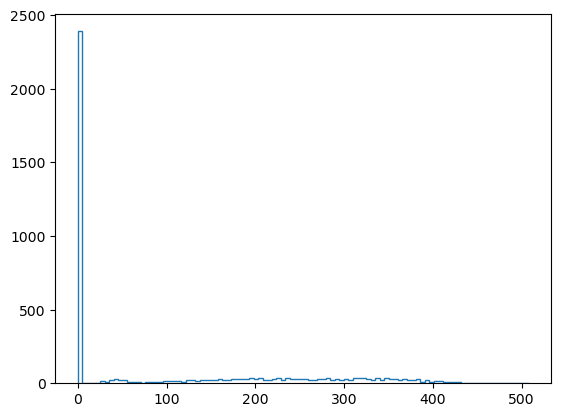

In [206]:
plt.hist(track_length_set_1, bins = 100, histtype = 'step');
filtair = np.argwhere((track_length_set_1>100)&(angle_track_set_1<5)&(angle_track_set_1>-15)).flatten()

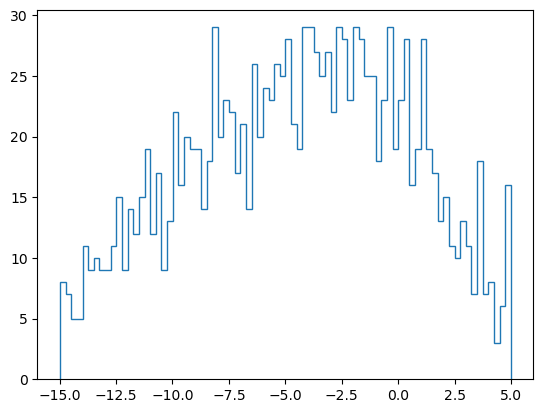

In [208]:
plt.hist(angle_track_set_1[filtair], bins  =80, histtype = 'step');

1428


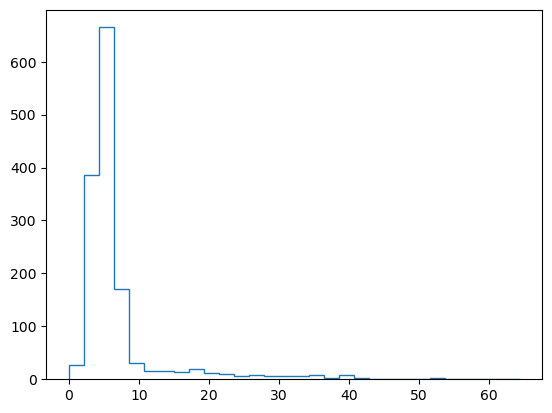

In [209]:
plt.hist(sigma_set_1[filtair], bins = 30, histtype = 'step');
print(len(sigma_set_1[filtair]))

Text(0.5, 1.0, 'Track Length v/s Angle of track')

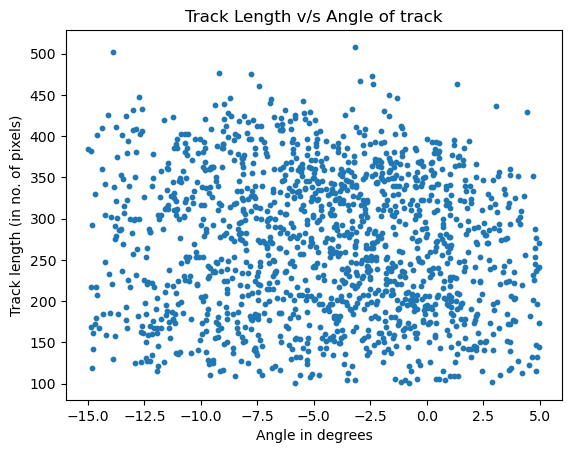

In [210]:
plt.scatter(angle_track_set_1[filtair], track_length_set_1[filtair], s=10)
plt.xlabel('Angle in degrees')
plt.ylabel('Track length (in no. of pixels)')
plt.title('Track Length v/s Angle of track')
#plt.savefig('Track Length - Angle of track')

Text(0, 0.5, 'Intnsity in DUI')

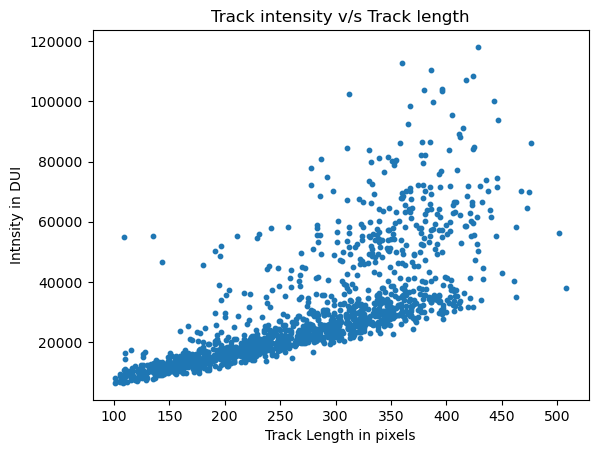

In [211]:
plt.scatter(track_length_set_1[filtair], intensity_set_1[filtair], s=10)
plt.title('Track intensity v/s Track length')
plt.xlabel('Track Length in pixels')
plt.ylabel('Intnsity in DUI')
#plt.savefig('Track intensity - Track length')

Text(0, 0.5, 'Intnsity in DUI')

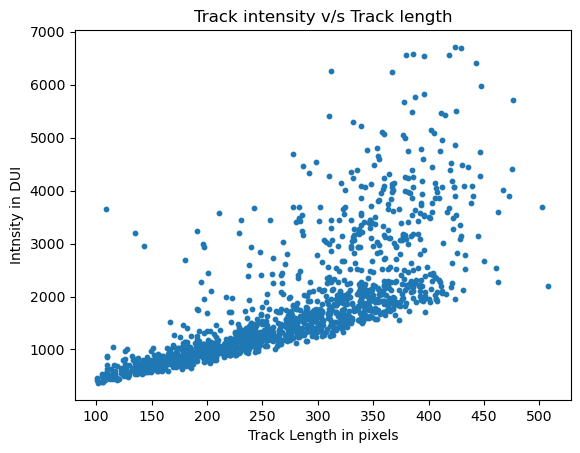

In [212]:
plt.scatter(track_length_set_1[filtair], nct_int_set_1[filtair], s=10)
plt.title('Track intensity v/s Track length')
plt.xlabel('Track Length in pixels')
plt.ylabel('Intnsity in DUI')
#plt.savefig('Track intensity - Track length')

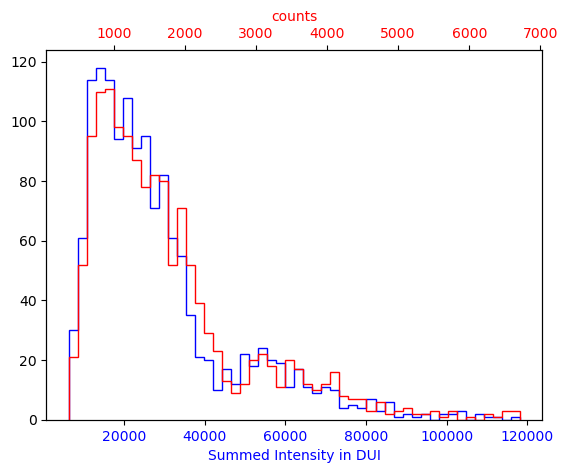

In [207]:
fig, ax1 = plt.subplots()

# First histogram (e.g., intensity)
ax1.hist(intensity_set_1[filtair], bins=50, histtype='step', color='blue', label='Intensity')
ax1.set_xlabel('Summed Intensity in DUI', color='blue')
ax1.tick_params(axis='x', labelcolor='blue')

# Twin x-axis
ax2 = ax1.twiny()
ax2.hist(nct_int_set_1[filtair], bins=50, histtype='step', color='red', label='Count Based Intensity')
ax2.set_xlabel('counts', color='red')
ax2.tick_params(axis='x', labelcolor='red')

#plt.title('Overlayed Histograms with Two X-Axes')
plt.savefig('Intensity Comparision katie without ransac.png')
plt.show()

In [41]:
file = files[35]
myflifile = FliFile(file)
data = myflifile.getdata()
print(data.shape)

(1920, 1200, 100)


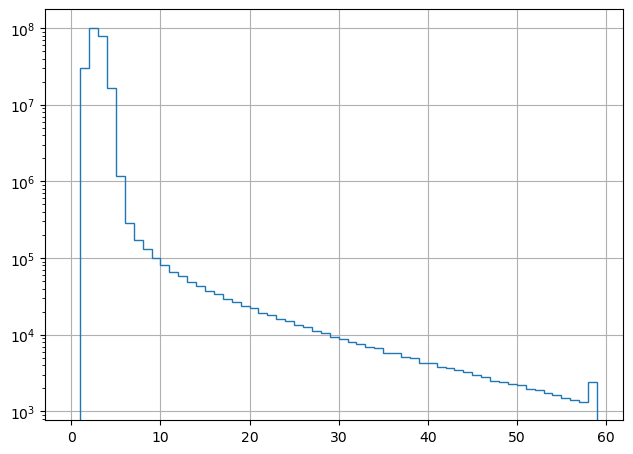

In [42]:
data = np.array(data, dtype = float)
plt.hist(data.flatten(), bins=np.arange(0, 60), histtype='step')
#plt.xticks(np.arange(0, 200, 1))  # set x-axis ticks at each integer
#plt.axvline(np.mean(data), color = 'r')
#plt.axvline(np.mean(data) + 3*np.std(data), color = 'r')
#plt.axvline(np.mean(data) - np.std(data), color = 'r')
plt.grid(True)
plt.tight_layout()
plt.yscale('log')
plt.show()

70


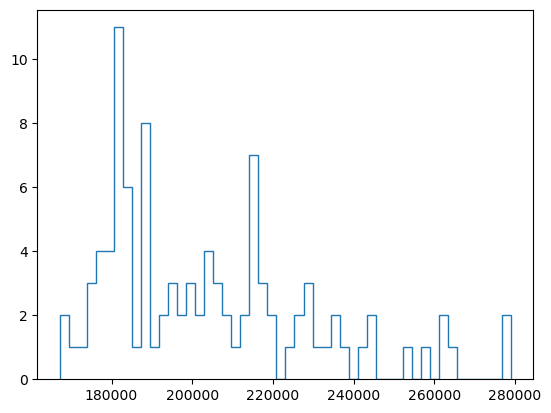

In [63]:
data_clear = np.where(data<6, 0, data)
clean_x = np.arange(0,99,1)
clean_y = np.array([(np.sum(data_clear[:,:,i])) for i in range(0,99)])
plt.hist(clean_y,bins = 50, histtype = 'step');
print(np.argmax(clean_y))

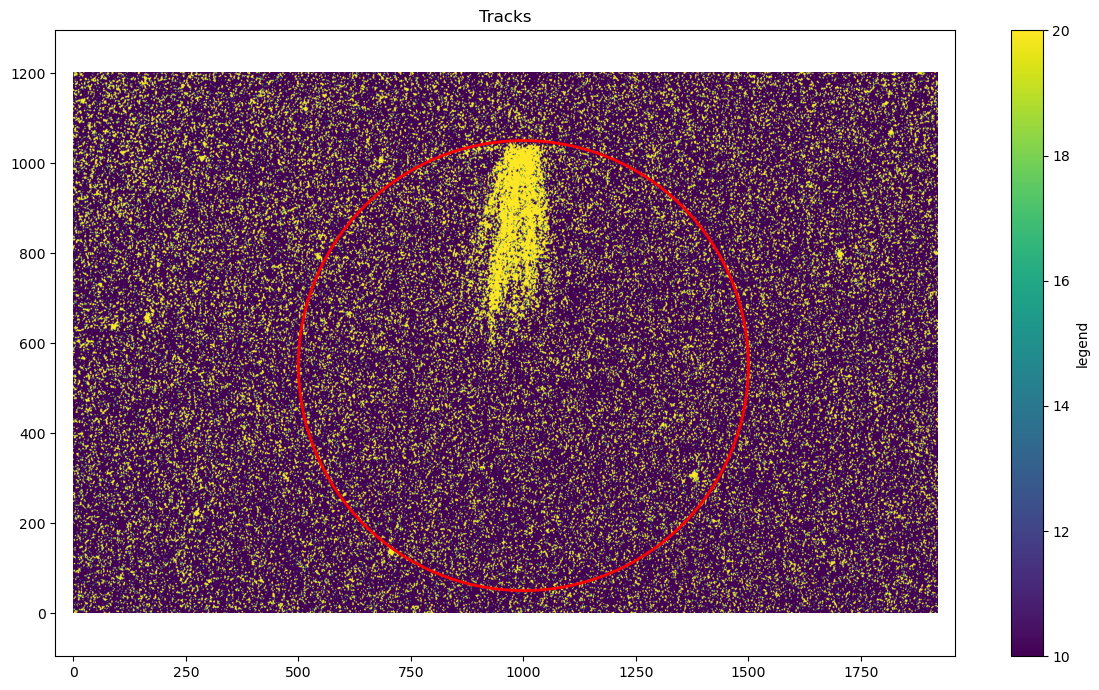

In [64]:
avl_data_sum = np.sum(data_clear, axis = 2)
image = avl_data_sum.T
center_x, center_y, radius = 1000, 550, 500
plt.figure(figsize=(12,7))
im = plt.imshow(image, cmap='viridis', origin='lower', aspect='auto', vmin=10, vmax=20)
plt.colorbar(im, label='legend')
ax = plt.gca()
circ = plt.Circle((center_x, center_y), radius, color='red', fill=False, lw=2)
ax.add_patch(circ)
plt.axis('equal')
plt.title('Tracks')
plt.tight_layout()
plt.savefig('Circle_window.png')
plt.show()

In [65]:
track_length_set_1 = np.array([])
angle_track_set_1 = np.array([])
energy_set_1 = np.array([])
sigma_set_1 = np.array([])
intensity_set_1 = np.array([])
int_1 = np.array([])

for i in range(0, 99):
    orig_image = data_clear[:, :, i].T
    masked_image = np.zeros_like(orig_image)

    # Create circular mask
    Y, X = np.ogrid[:orig_image.shape[0], :orig_image.shape[1]]
    dist_from_center = np.sqrt((X - center_x) ** 2 + (Y - center_y) ** 2)
    mask = dist_from_center <= radius

    # Apply mask
    masked_image[mask] = orig_image[mask]
    a = np.sum(masked_image)
    int_1 = np.append(int_1, a)

np.int64(24)

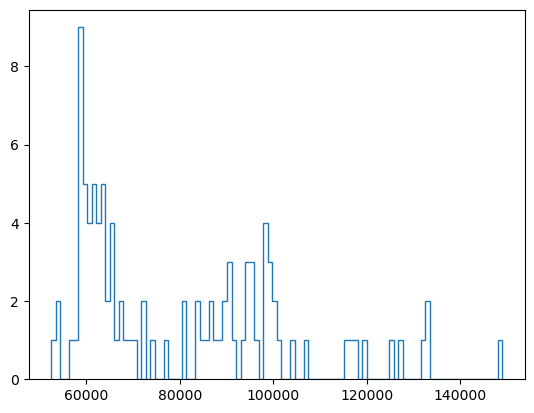

In [66]:
plt.hist(int_1, bins =100, histtype = 'step');
np.argmax(int_1)

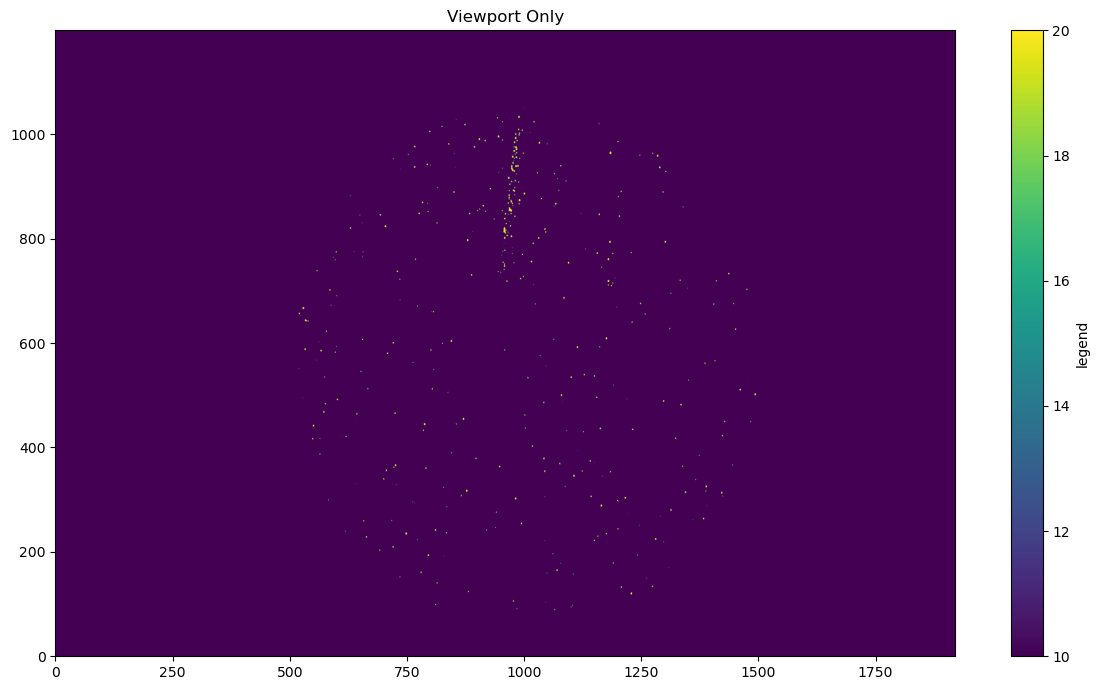

In [68]:
orig_image = data_clear[:,:,23].T
masked_image = np.zeros_like(orig_image)

# Create circular mask
Y, X = np.ogrid[:orig_image.shape[0], :orig_image.shape[1]]
dist_from_center = np.sqrt((X - center_x)**2 + (Y - center_y)**2)
mask = dist_from_center <= radius

# Apply mask
masked_image[mask] = orig_image[mask]

# Plot to check
plt.figure(figsize=(12, 7))
plt.imshow(masked_image, cmap='viridis', origin='lower', aspect='auto', vmin=10, vmax=20)
plt.colorbar(label='legend')
plt.title('Viewport Only')
plt.tight_layout()
plt.show()

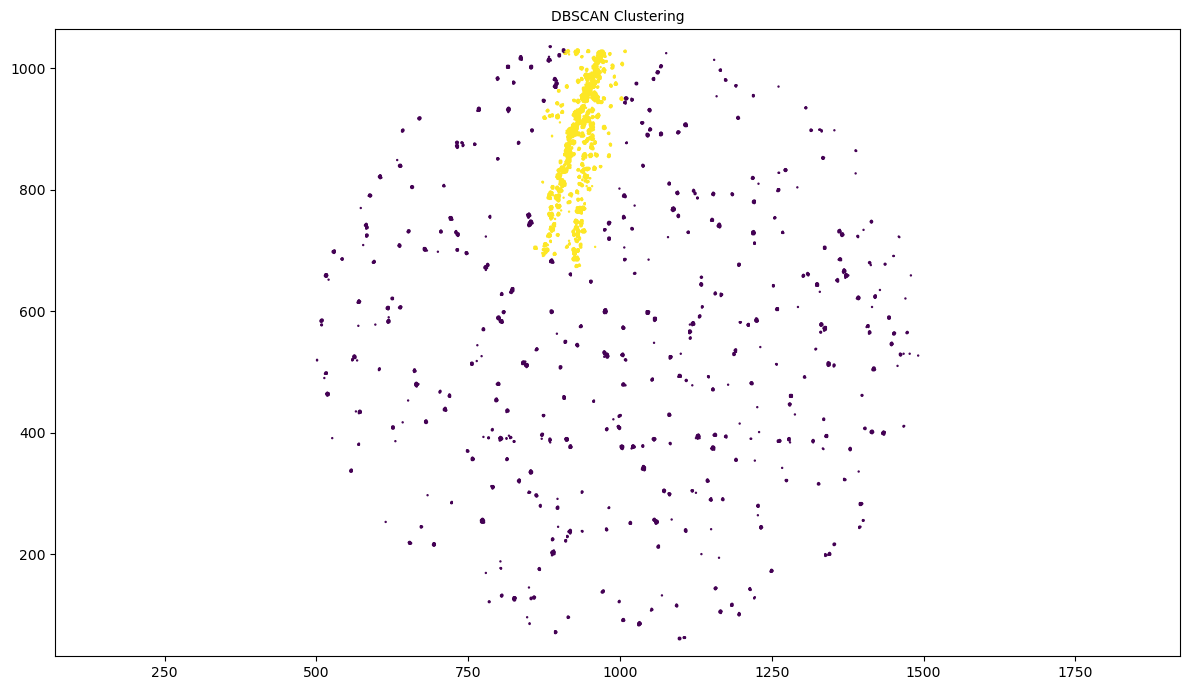

69
1


In [150]:
idx = np.random.choice(np.arange(0,100))

orig_image = data_clear[:,:,idx].T
masked_image = np.zeros_like(orig_image)

# Create circular mask
Y, X = np.ogrid[:orig_image.shape[0], :orig_image.shape[1]]
dist_from_center = np.sqrt((X - center_x)**2 + (Y - center_y)**2)
mask = dist_from_center <= radius

# Apply mask
masked_image[mask] = orig_image[mask]

# Plot to check
# plt.figure(figsize=(12, 7))
# plt.imshow(masked_image, cmap='viridis', origin='lower', aspect='auto', vmin=10, vmax=20)
# plt.colorbar(label='legend')
# plt.title(f'Viewport Only, idx{idx}')
# plt.tight_layout()
# plt.show()

#Binarise image
BinThr = 0
binary_image = np.where(masked_image>BinThr,1,0)

#Make coordinates
coords = np.nonzero(binary_image)
coords_array = np.column_stack(coords)

#DBSCAN CLUSTERING
cluster_size_array = np.zeros(4200)
count = 0
#time_start_dbscan = timeit.default_timer
db_eps = 29
db_min_samp = 200
dbscan  = DBSCAN(eps = db_eps, min_samples = db_min_samp)
dbscan.fit(coords_array)
labels = dbscan.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
if n_clusters_>0:
    clusters = [coords_array[labels == i] for i in range(n_clusters_)]
    clusters_size=[len(clusters[i]) for i in range(n_clusters_)]
    all_clusters= coords_array[labels!= -1]
    max_cluster=np.max(clusters_size) #how big is largest cluster
    cluster_size_array[count+1]=max_cluster
    ind=np.array(clusters[np.argmax(clusters_size)])  #indices of points in largest cluster
    if max_cluster > 0:   #Threshold for track
        cluster_image = np.zeros_like(orig_image)
        fig=plt.figure(figsize=(12,7))
        plt.scatter(coords_array[:,1],coords_array[:,0],c=labels,s=0.5)
        plt.title('DBSCAN Clustering',fontsize=10)
        plt.xlim([0,1920])
        plt.ylim([0,1200])
        plt.axis('equal')
        plt.tight_layout()
        plt.show()
print(idx)
print(n_clusters_)

4761
4761


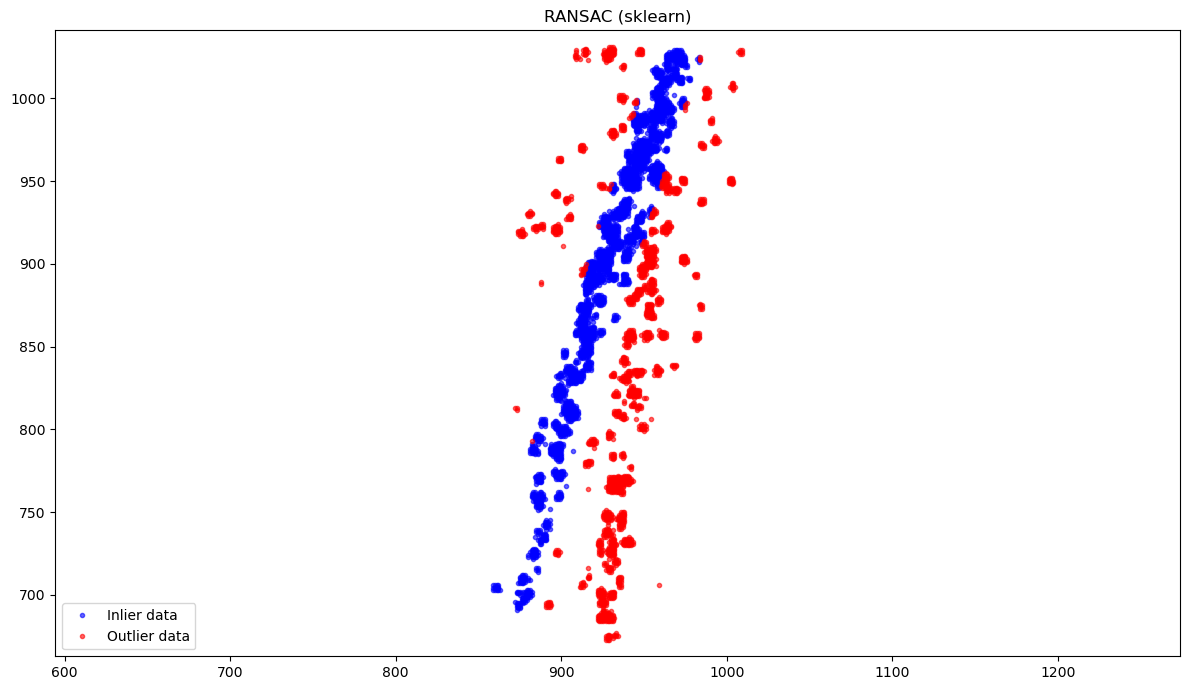

In [151]:
X = ind[:, 0].reshape(-1, 1)  # Feature: column index 1
y = ind[:, 1]                 # Target: column index 0

# Define RANSACRegressor with same parameters
ransac = RANSACRegressor(
    estimator=LinearRegression(),
    min_samples=10,
    residual_threshold=15,
    max_trials=1000,
    stop_score = 0.95
)

# Fit it
ransac.fit(X, y)

# Get inlier mask
inliers = ransac.inlier_mask_
outliers = ~inliers  # Logical NOT

print(len(y))
print(len(inliers))
# Plot same way
plt.figure(figsize=(12, 7))
plt.plot(y[inliers], X[inliers], '.b', alpha=0.6, label='Inlier data')
plt.plot(y[outliers], X[outliers], '.r', alpha=0.6, label='Outlier data')
plt.legend(loc='lower left')
plt.axis("equal")
plt.title('RANSAC (sklearn)')
plt.tight_layout()
plt.show()

In [154]:
track_length_set_1 = np.zeros(100)
angle_track_set_1 = np.zeros(100)
energy_set_1 = np.zeros(100)
sigma_set_1 = np.zeros(100)
intensity_set_1 = np.zeros(100)
nct_int_set_1 = np.zeros(100)
track  = np.zeros((1920,1200,100))

for i in range(0, 100):
    orig_image = data_clear[:, :, i].T
    masked_image = np.zeros_like(orig_image)

    # Create circular mask
    Y, X = np.ogrid[:orig_image.shape[0], :orig_image.shape[1]]
    dist_from_center = np.sqrt((X - center_x) ** 2 + (Y - center_y) ** 2)
    mask = dist_from_center <= radius

    # Apply mask
    masked_image[mask] = orig_image[mask]

    # Binarise image
    binary_image = np.where(masked_image > 0, 1, 0)

    # Make coordinates
    coords = np.nonzero(binary_image)
    coords_array = np.column_stack(coords)

    # DBSCAN CLUSTERING
    cluster_size_array = np.zeros(4200)
    count = 0
    db_eps = 29
    db_min_samp = 200
    dbscan = DBSCAN(eps=db_eps, min_samples=db_min_samp)
    dbscan.fit(coords_array)
    labels = dbscan.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    if n_clusters_ > 0:
        clusters = [coords_array[labels == i] for i in range(n_clusters_)]
        clusters_size = [len(clusters[i]) for i in range(n_clusters_)]
        all_clusters = coords_array[labels != -1]
        max_cluster = np.max(clusters_size)  # how big is largest cluster
        cluster_size_array[count + 1] = max_cluster
        ind = np.array(clusters[np.argmax(clusters_size)])  # indices of points in largest cluster
        
        X = ind[:, 0].reshape(-1, 1)  # Feature: column index 1
        y = ind[:, 1]                 # Target: column index 0

        # Define RANSACRegressor with same parameters
        ransac = RANSACRegressor(
            estimator=LinearRegression(),
            min_samples=10,
            residual_threshold=15,
            max_trials=1000,
            stop_score = 0.95
        )

        # Fit it
        ransac.fit(X, y)

        # Get inlier mask
        inliers = ransac.inlier_mask_
        outliers = ~inliers  # Logical NOT

        #Cluster_mask in case you want to plot in future
        cluster_mask = np.zeros_like(orig_image)
        x = ind[inliers,0]
        y = ind[inliers,1]
        for j in range(len(x)):
            x_j = x[j]
            y_j = y[j]
            cluster_mask[x_j,y_j] = 1
        Track = masked_image*cluster_mask


        # PCA From here
        X = np.column_stack((x, y))
        pca = PCA(n_components=2)
        pca.fit(X)
        for length, vector in zip(pca.explained_variance_, pca.components_):
            v = vector * 2.5 * np.sqrt(length)
            start_point = pca.mean_ - v
            end_point = pca.mean_ + v

        # Building Component 1
        length = pca.explained_variance_[0]
        vector = pca.components_[0]
        v = vector * np.sqrt(length)

        mean = pca.mean_
        end_midpoint = mean + 0.5 * v
        start_midpoint = mean - 0.5 * v
        end_point = mean + 1 * v
        start_point = mean - 1 * v
        pca1_start_point = mean - 2.5 * v
        pca1_end_point = mean + 2.5 * v

        length_v_pca1 = int(np.linalg.norm(v))

        width_of_line = 15
        profile_pc1 = skimage.measure.profile_line(
            Track,
            pca1_end_point,
            pca1_start_point,
            linewidth=width_of_line,
            mode='constant',
            cval=0,
            reduce_func=np.sum
        )

        # Building Component 2
        length = pca.explained_variance_[1]
        vector = pca.components_[1]
        v = vector * 3 * np.sqrt(length)
        cut1_start = start_point - v
        cut1_end = start_point + v
        cut2_start = start_midpoint - v
        cut2_end = start_midpoint + v
        cut3_start = mean - v
        cut3_end = mean + v
        cut4_start = end_midpoint - v
        cut4_end = end_midpoint + v
        cut5_start = end_point - v
        cut5_end = end_point + v

        start = (cut3_start[0], cut3_end[0])
        end = (cut3_start[1], cut3_end[1])
        profile_pc2 = skimage.measure.profile_line(
            Track,
            cut3_start,
            cut3_end,
            linewidth=100,
            mode='constant',
            cval=0,
            reduce_func=np.sum
        )

        # Track length
        non_zero_elements = np.where(profile_pc1 > 0)
        first_non_zero_index = non_zero_elements[0][0]
        last_non_zero_index = non_zero_elements[0][-1]
        track_length_pixels = last_non_zero_index - first_non_zero_index
        track_length = track_length_pixels

        # Direction of Track
        direction_vector = pca.components_[0]
        # Clockwise from zero at source is negative, Anticlockwise is positive
        angle = -(90 - math.degrees(math.atan(direction_vector[0] / direction_vector[1])))
        if np.abs(angle) > 90:
            angle = 180 + angle

        track_length_set_1[i] = track_length
        angle_track_set_1[i] = angle

        #Energy and dE/dx
        Energy = np.sum(Track)
        de_dx = Energy/track_length
        energy_set_1[i] = de_dx
        intensity_set_1[i] = Energy

        #Sigma
        # Define the Gaussian function function to fit
        def gaussian(x, a, mu, sigma):
            return a*np.exp(-(x-mu)**2/(2*sigma**2))
                        
        #define data
        xdata=np.linspace(1,len(profile_pc2),num=len(profile_pc2)) 
        ydata=profile_pc2
    
        # fit the data and plot the result

        param, cov = curve_fit(gaussian, xdata,ydata, p0=(300,sum(xdata*ydata/sum(ydata)),5))
        amp_gaus  = param[0] #amplitude 
        mean_gaus = param[1] #mean of gaussian dist
        std_gaus = abs(param[2]) #stdev of the dist
        sigma= std_gaus
        sigma_set_1[i] = sigma

        #nct_intensity
        nct = np.count_nonzero(Track)
        nct_int_set_1[i] = nct

        #Adding track 
        track[:,:,i] = Track.T

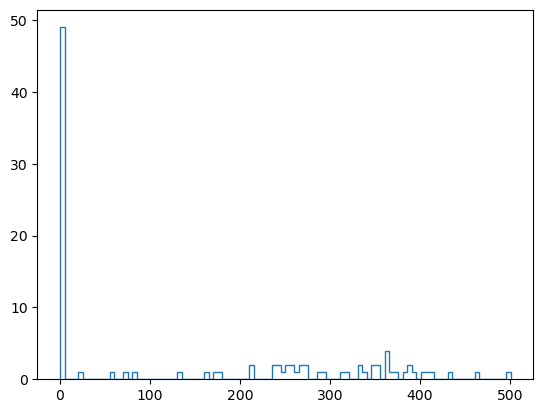

In [159]:
plt.hist(track_length_set_1, bins = 100, histtype = 'step');
filtair = np.argwhere((track_length_set_1>100)&(sigma_set_1<10)).flatten()

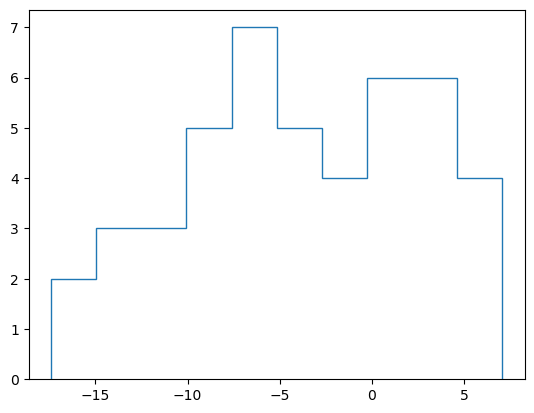

In [162]:
plt.hist(angle_track_set_1[filtair], histtype = 'step');

45


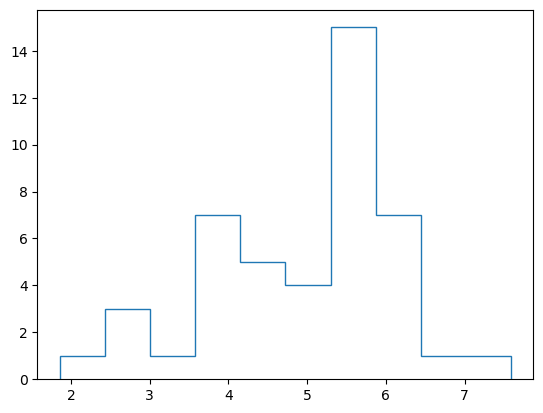

In [164]:
plt.hist(sigma_set_1[filtair], histtype = 'step');
print(len(sigma_set_1[filtair]))

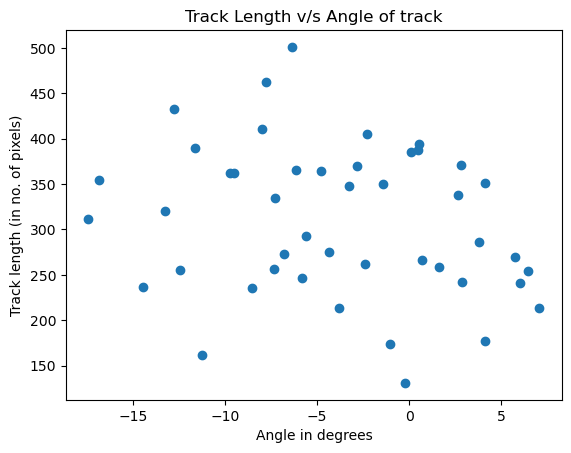

In [165]:
plt.scatter(angle_track_set_1[filtair], track_length_set_1[filtair])
plt.xlabel('Angle in degrees')
plt.ylabel('Track length (in no. of pixels)')
plt.title('Track Length v/s Angle of track')
plt.savefig('Track Length - Angle of track')